In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

##############################################################################
# 1) Define the tag lists for each matching type
##############################################################################

EXACT_TAGS = [
    "ConvCourtName",
    "Confess/Plead",
    "SentCourtName",
    "SentServe",
    "OffSex",
    "OffAgeOffence",
    "OffIntoxOffence",
    "VictimType",
    "VicNum",
    "VicSex",
    "VicAgeOffence",
    "VicIntoxOffence",
    "PreSentReport",
    "VicImpactStatement",
    "Appellant",
    "AppealAgainst",
    "AppealOutcome"
]

PARTIAL_TAGS = [
    "ConvictPleaDate",
    "ConvictOffence",
    "AcquitOffence",
    "PleaPoint",
    "RemandDecision",
    "RemandCustodyTime",
    "Sentence",
    "WhatAncilliary",
    "OffJobOffence",
    "OffHomeOffence",
    "OffMentalOffence",
    "OffVicRelation",
    "VicJobOffence",
    "VicHomeOffence",
    "VicMentalOffence",
    "ProsEvidTypeTrial",
    "DefEvidTypeTrial",
    "AggFactSent",
    "MitFactSent",
    "Co-defendants/co-accused",
    "CoDefAccNum",
    "SentGuideWhich",
    "AppealGround",
    "ReasonQuashConv",
    "ReasonSentExcess",
    "ReasonSentLenient",
    "ReasonDismiss"
]

##############################################################################
# 2) Helper function to extract annotation content
##############################################################################
def extract_content(text):
    """
    Splits an annotation string into its 'Exact:' and 'Comment:' parts.
    Returns two strings: (exact_part, comment_part).
    If 'Exact:' or 'Comment:' are missing, returns two empty strings.
    """
    if 'Exact:' in text and 'Comment:' in text:
        parts = text.split('Comment:')
        exact = parts[0].replace('Exact:', '').strip()
        comment = parts[1].strip()
        return exact, comment
    return '', ''


##############################################################################
# 3) Comparison function (same as before but using our tag filtering mode)
##############################################################################
def compare_dataframes_specific(file1, file2, tag_filter, mode="exact"):
    """
    Compares two annotation CSV files for only the tags provided in tag_filter.
    Assumes each CSV has a column 'tag_name' (which holds the tag for that row).
    For each common tag in the filtered data, all other columns are compared field‐by‐field:
       - In "exact" mode, a match is counted only if the two values are identical.
       - In "partial" mode, if the values differ but (provided both are non-empty)
         a substring check is performed on the extracted "Exact:" and "Comment:" parts.
    
    Returns a DataFrame with:
       - "Tag Name"
       - For mode "exact": "Exact Match" (ratio of fields that match exactly)
       - For mode "partial": "Partial Match" (ratio including both exact and substring matches)
    """
    df1 = pd.read_csv(file1, na_filter=False)
    df2 = pd.read_csv(file2, na_filter=False)
    
    # Filter rows by the desired tag set.
    if 'tag_name' not in df1.columns or 'tag_name' not in df2.columns:
        print("Warning: 'tag_name' column not found in one of the files.")
        return pd.DataFrame()
    df1 = df1[df1['tag_name'].isin(tag_filter)]
    df2 = df2[df2['tag_name'].isin(tag_filter)]
    
    # Keep only common columns.
    common_columns = df1.columns.intersection(df2.columns)
    if 'tag_name' not in common_columns:
        print("Warning: 'tag_name' column missing after filtering.")
        return pd.DataFrame()
    
    # We will compare all columns except 'tag_name'.
    case_columns = common_columns.drop(['tag_name'])
    
    tag_names = []
    metric_values = []  # Either exact or partial match ratio.
    
    for tag in df1['tag_name']:
        if tag in df2['tag_name'].values:
            tag_names.append(tag)
            total_fields = len(case_columns)
            count = 0  # Count of matching fields
            for col in case_columns:
                val1 = df1.loc[df1['tag_name'] == tag, col].values[0]
                val2 = df2.loc[df2['tag_name'] == tag, col].values[0]
                if mode == "exact":
                    if val1 == val2:
                        count += 1
                elif mode == "partial":
                    if val1 == val2:
                        count += 1
                    else:
                        if val1.strip() and val2.strip():
                            exact1, comment1 = extract_content(val1)
                            exact2, comment2 = extract_content(val2)
                            if (exact1 in exact2 or exact2 in exact1 or 
                                comment1 in comment2 or comment2 in comment1):
                                count += 1
            ratio = count / total_fields if total_fields else 0
            metric_values.append(ratio)
            
    if mode == "exact":
        result_df = pd.DataFrame({
            "Tag Name": tag_names,
            "Exact Match": metric_values
        })
    else:  # mode == "partial"
        result_df = pd.DataFrame({
            "Tag Name": tag_names,
            "Partial Match": metric_values
        })
    return result_df



In [10]:
##############################################################################
# 4) Plotting functions
##############################################################################
def plot_overlayed_comparison(metric, df_list, labels, tag_order, title="", reference_line=0.8, output_file=None):
    """
    Plots a grouped horizontal bar chart overlaying multiple comparisons on one axes.
    
    Parameters:
      - metric: Either "Exact Match" or "Partial Match" (the column name in each DF).
      - df_list: A list of DataFrames, each having columns "Tag Name" and the metric.
      - labels: A list of labels corresponding to each DF in df_list.
      - tag_order: A list of tag names in the desired order (use EXACT_TAGS or PARTIAL_TAGS).
      - title: Overall title of the plot.
      - reference_line: A vertical reference (e.g., 0.8 for 80%).
    """
    # Number of comparisons (series)
    n_series = len(df_list)
    
    # Build a list of values (one per series) in the order of tag_order.
    # For each DataFrame, create a list of metric values corresponding to tag_order.
    series_values = []
    for df in df_list:
        d = df.set_index("Tag Name")[metric].to_dict()
        # Use 0 if tag missing.
        values = [d.get(tag, 0) for tag in tag_order]
        series_values.append(values)
        
    indices = np.arange(len(tag_order))
    total_group_height = 0.8
    bar_height = total_group_height / n_series
    # Offsets for each series so that they are centered in each group.
    offsets = -total_group_height/2 + bar_height/2 + np.arange(n_series)*bar_height
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Colors for each series (you can adjust or let Matplotlib assign automatically).
    colors = ['darkblue', 'darkorange', 'green', 'purple']
    # Plot each series' horizontal bars with its offset.
    for i, (values, label) in enumerate(zip(series_values, labels)):
        pos = indices + offsets[i]
        ax.barh(pos, values, height=bar_height, label=label, color=colors[i % len(colors)], edgecolor='black')
    
    ax.set_yticks(indices)
    ax.set_yticklabels(tag_order)
    ax.invert_yaxis()  # so the first tag appears at the top
    ax.set_xlabel("Agreement Ratio")
    ax.set_title(title)
    ax.axvline(x=reference_line, color='red', linestyle='--')
    # Optional: Add a vertical text label for the reference line.
    y_mid = (len(tag_order) - 1) / 2.0
    ax.text(reference_line + 0.01, y_mid, f"{int(reference_line*100)}% Ref", rotation=90, va='center', color='red')
    ax.grid(axis='x', linestyle=':', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    
    # 10) Optionally save
    if output_file:
        plt.savefig(output_file, facecolor='white', bbox_inches='tight')

    # 11) Show the plot
    plt.show()
    
    plt.show()

In [11]:
##############################################################################
# 5) File comparisons using the same file sets as before
##############################################################################

# File names for comparisons:
# Inter-Rater (OLD)
inter_vili_file    = 'updated_Curation_in_detail - Vili.csv'
inter_charis_file  = 'updated_Curation_in_detail - Charis.csv'

# Inter-Rater (NEW)
new_inter_vili_file   = 'intra_updated_Intra_rater-dataset_curation_citations - Curation_in_detail (Vili).csv'
new_inter_charis_file = 'intra_updated_Intra_rater-dataset_curation_citations - Curation_in_detail (Charis).csv'

# Intra-Rater Vili
updated_vili_file = 'intra_updated_Intra_rater-dataset_curation_citations - Curation_in_detail (Vili).csv'
test_vili_file    = 'intra_self_validation_updated_Curation_in_detail - Vili.csv'

# Intra-Rater Charis
updated_charis_file = 'intra_updated_Intra_rater-dataset_curation_citations - Curation_in_detail (Charis).csv'
test_charis_file    = 'intra_self_validation_updated_Curation_in_detail - Charis.csv'



In [12]:
##############################################################################
# 6) Compute comparisons for each scenario and matching type
##############################################################################

# --- Exact Matching Comparisons ---
exact_inter_old   = compare_dataframes_specific(inter_vili_file, inter_charis_file, EXACT_TAGS, mode="exact")
exact_inter_new   = compare_dataframes_specific(new_inter_vili_file, new_inter_charis_file, EXACT_TAGS, mode="exact")
exact_intra_vili  = compare_dataframes_specific(updated_vili_file, test_vili_file, EXACT_TAGS, mode="exact")
exact_intra_charis = compare_dataframes_specific(updated_charis_file, test_charis_file, EXACT_TAGS, mode="exact")

# --- Partial (General) Matching Comparisons ---
partial_inter_old   = compare_dataframes_specific(inter_vili_file, inter_charis_file, PARTIAL_TAGS, mode="partial")
partial_inter_new   = compare_dataframes_specific(new_inter_vili_file, new_inter_charis_file, PARTIAL_TAGS, mode="partial")
partial_intra_vili  = compare_dataframes_specific(updated_vili_file, test_vili_file, PARTIAL_TAGS, mode="partial")
partial_intra_charis = compare_dataframes_specific(updated_charis_file, test_charis_file, PARTIAL_TAGS, mode="partial")


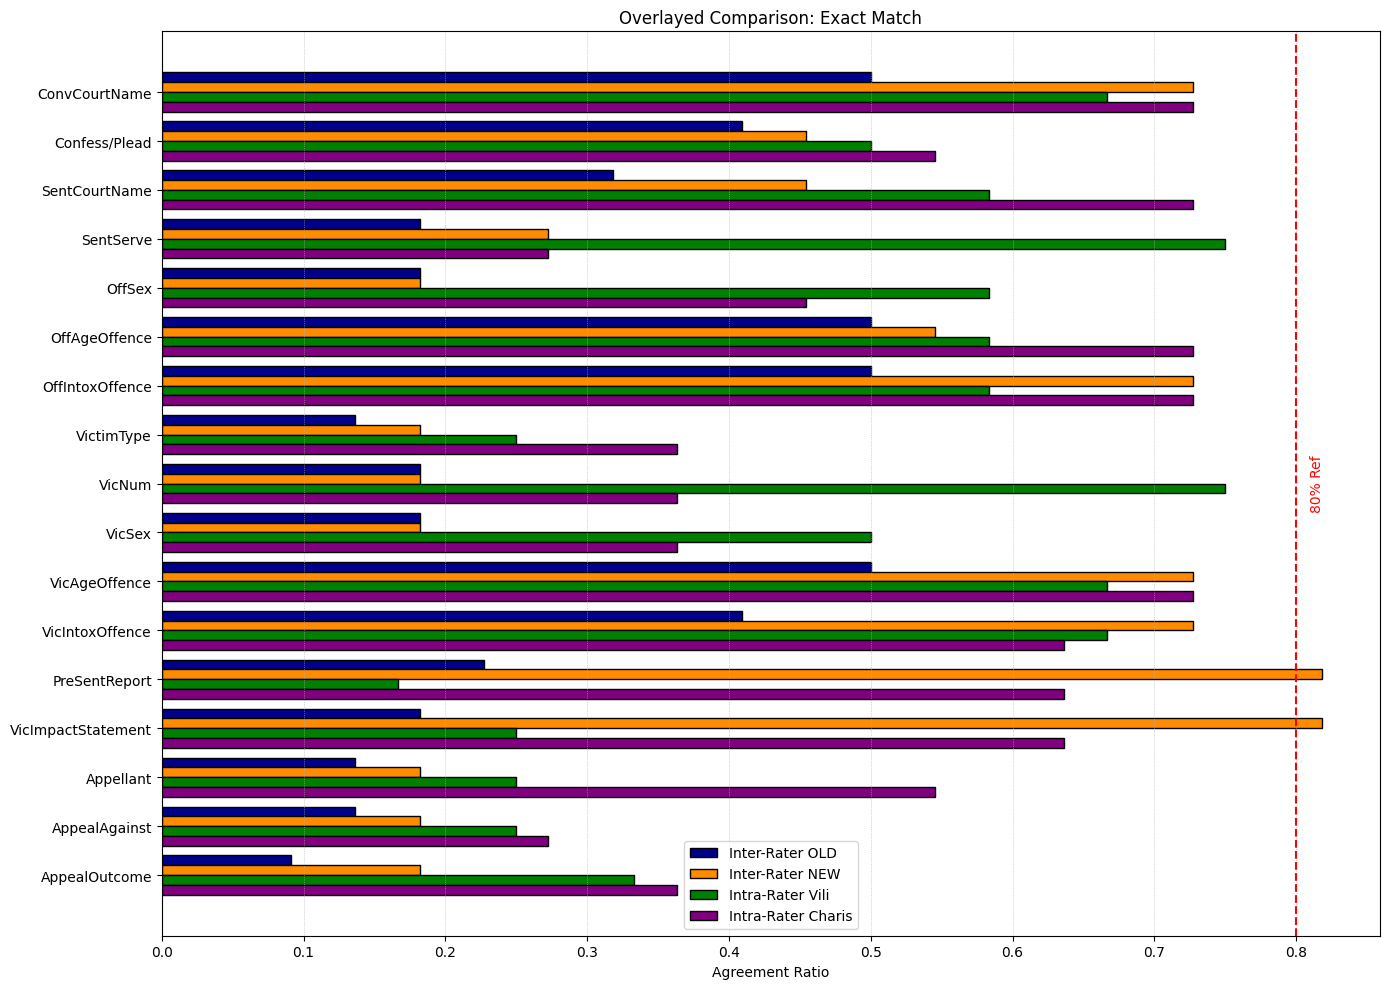

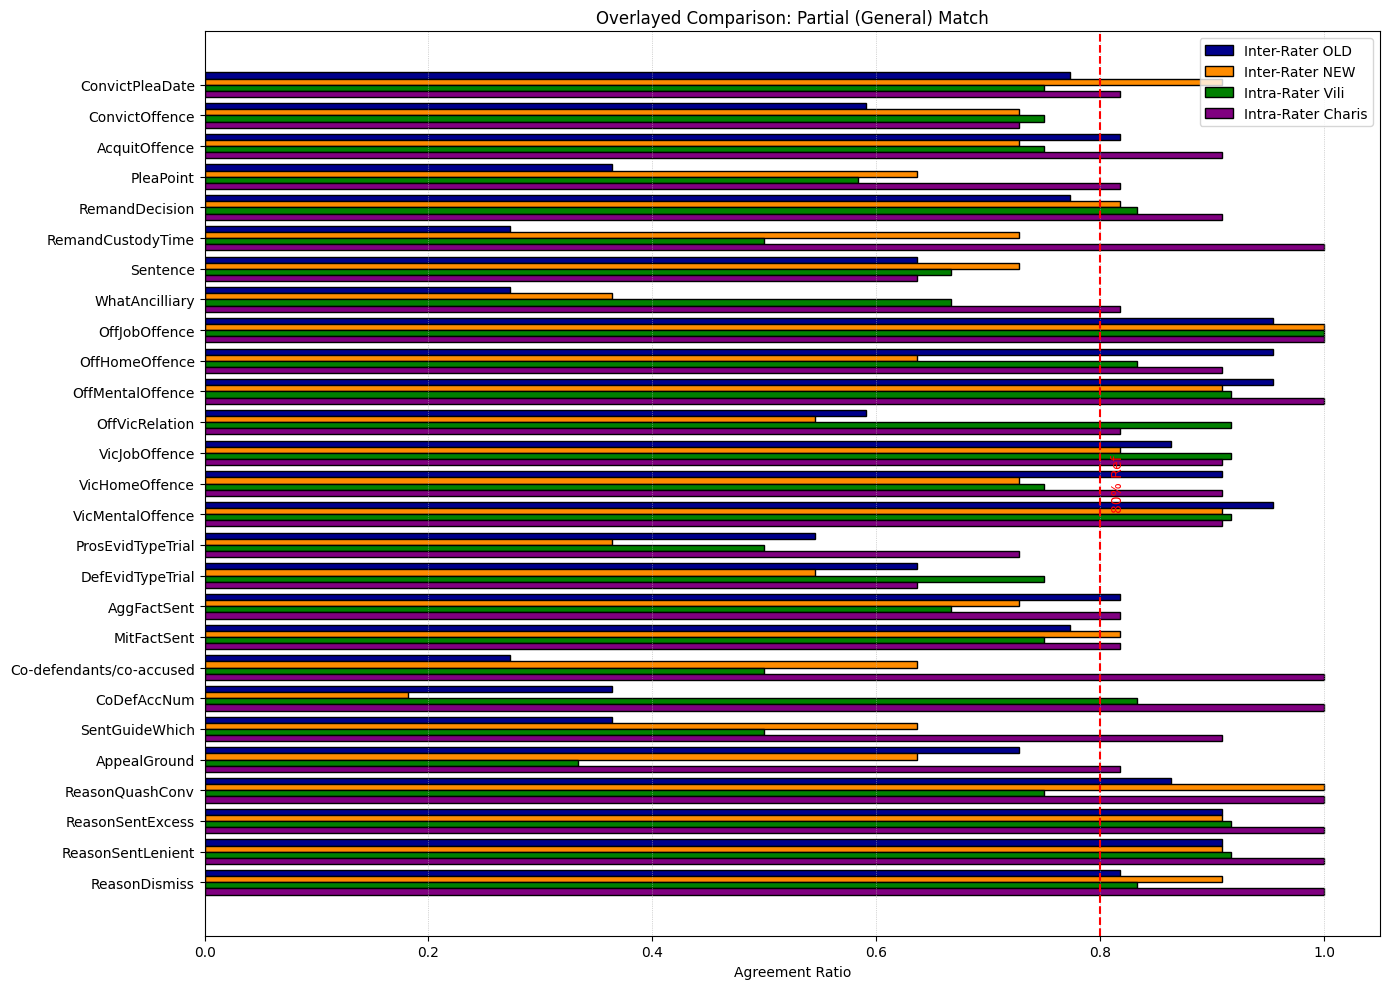

In [13]:
##############################################################################
# 7) Generate Overlayed Figures
##############################################################################

# Labels for the 4 comparisons:
comparison_labels = ["Inter-Rater OLD", "Inter-Rater NEW", "Intra-Rater Vili", "Intra-Rater Charis"]

# --- Overlayed Figure for Exact Matching ---
plot_overlayed_comparison(
    metric="Exact Match",
    df_list=[exact_inter_old, exact_inter_new, exact_intra_vili, exact_intra_charis],
    labels=comparison_labels,
    tag_order=EXACT_TAGS,
    title="Overlayed Comparison: Exact Match",
    reference_line=0.8
)

# --- Overlayed Figure for Partial (General) Matching ---
plot_overlayed_comparison(
    metric="Partial Match",
    df_list=[partial_inter_old, partial_inter_new, partial_intra_vili, partial_intra_charis],
    labels=comparison_labels,
    tag_order=PARTIAL_TAGS,
    title="Overlayed Comparison: Partial (General) Match",
    reference_line=0.8
)

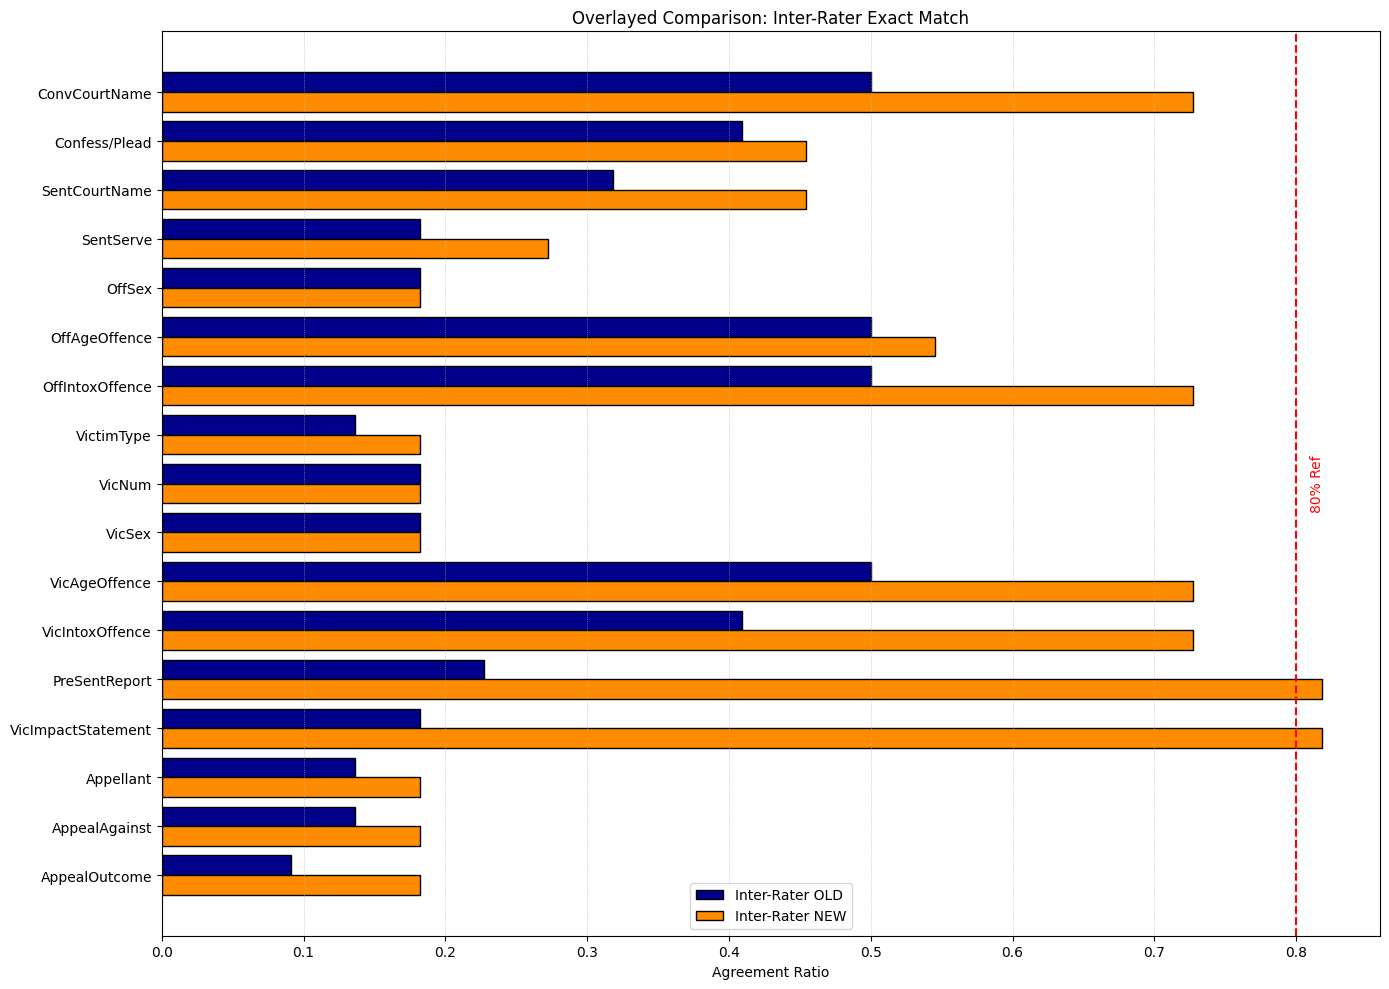

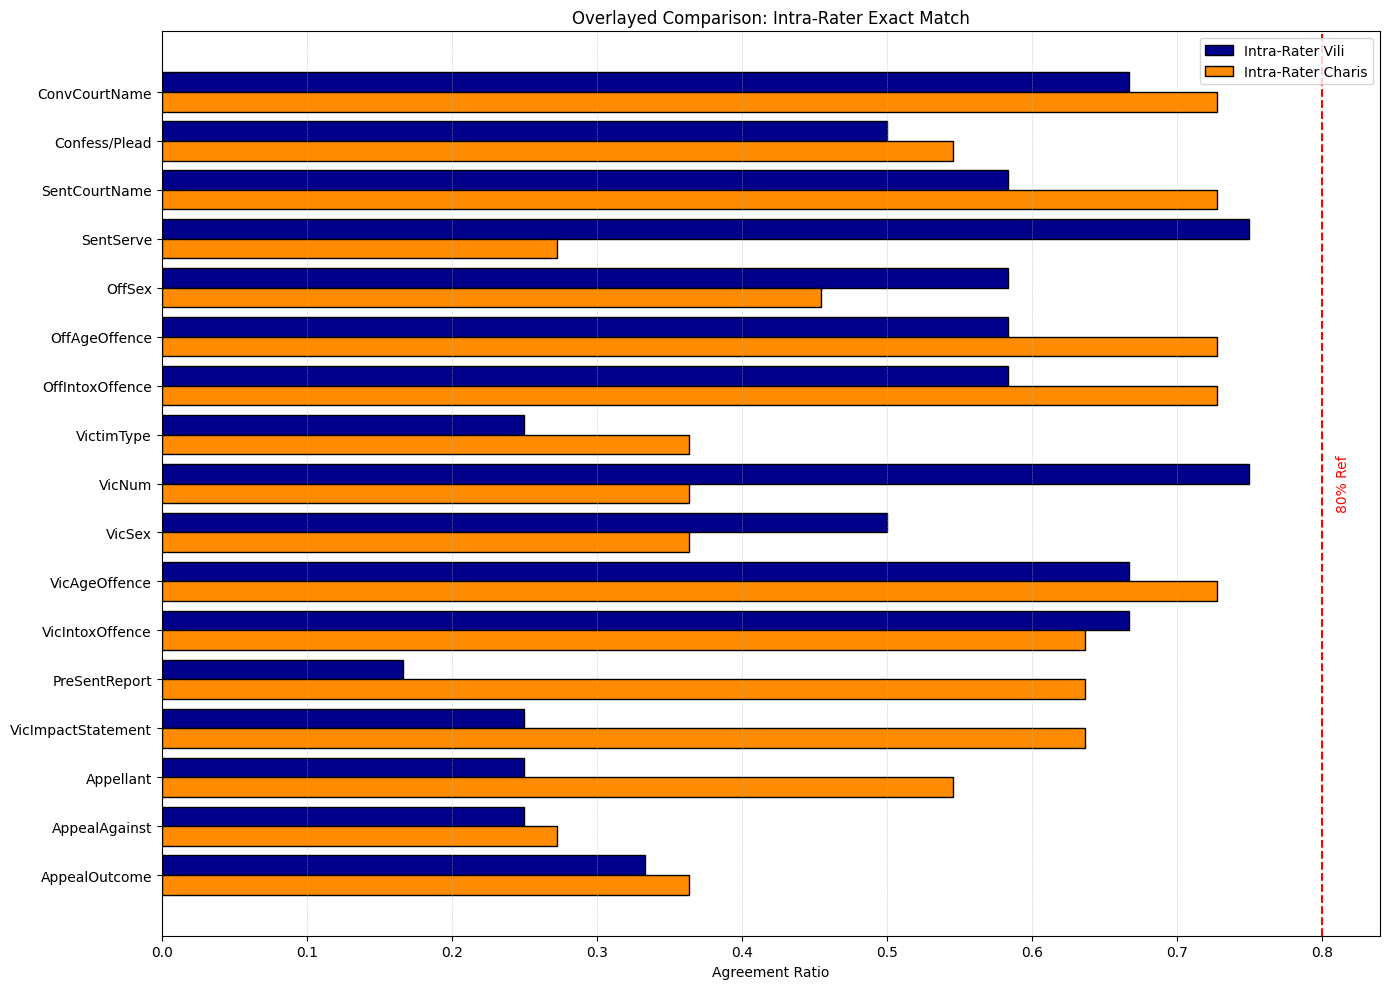

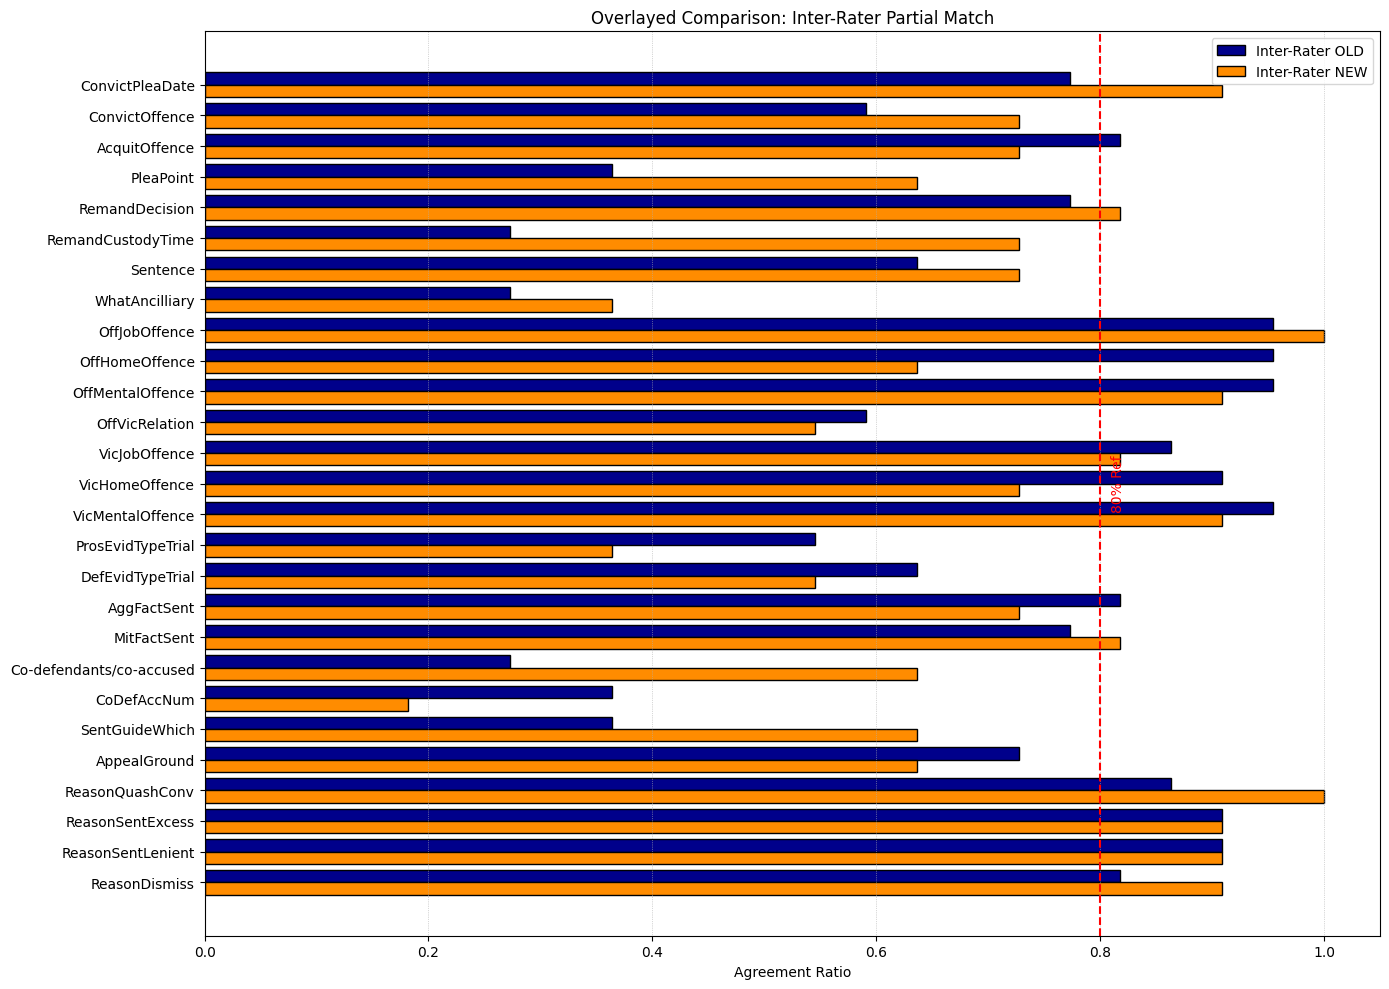

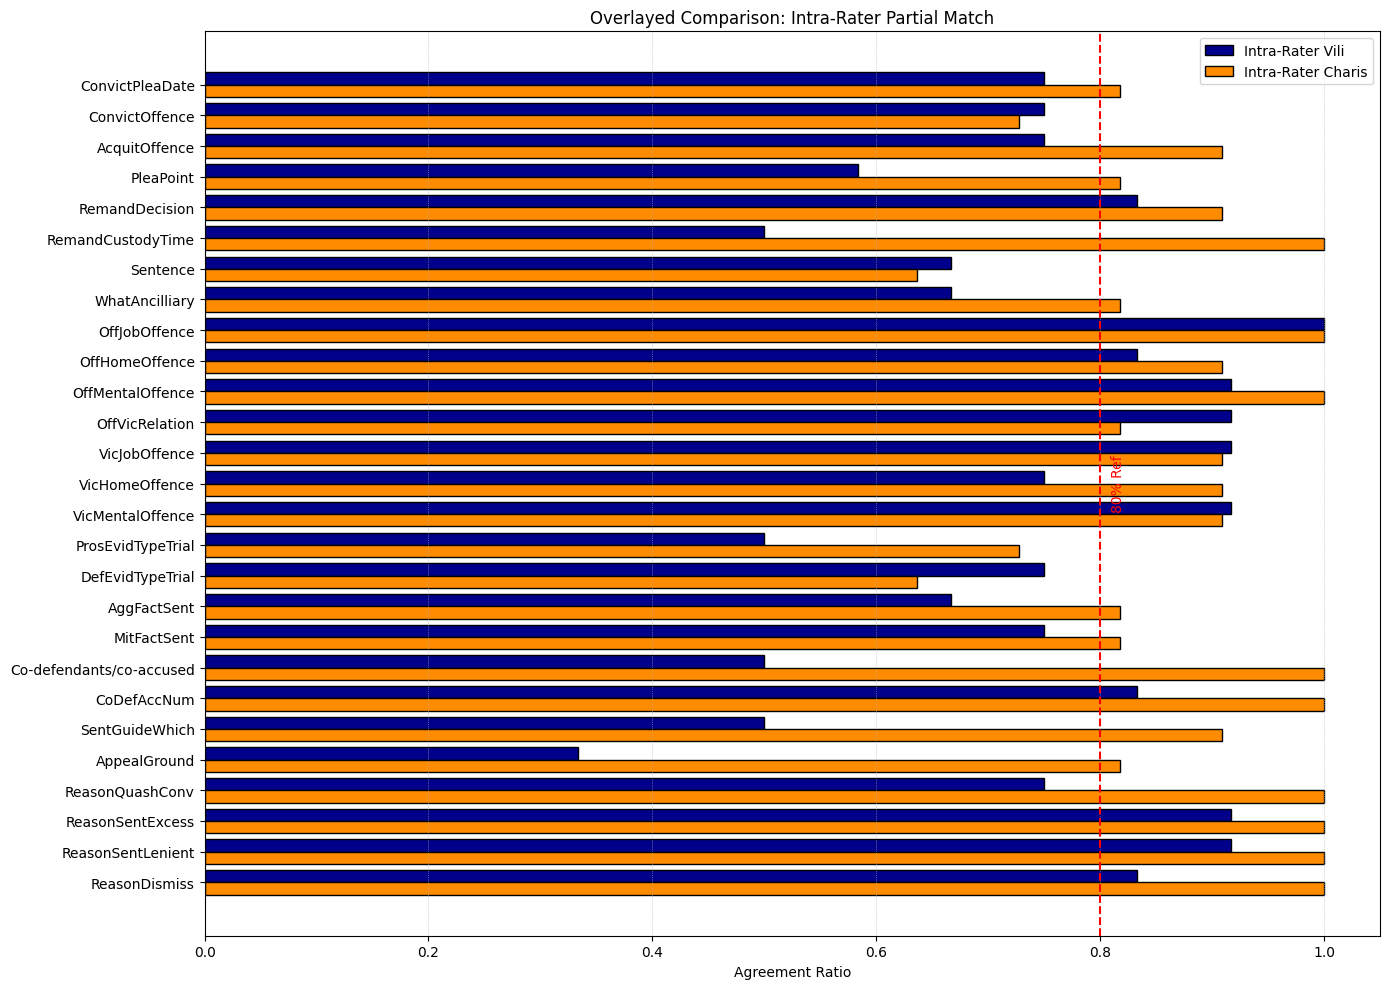

In [14]:
# Define the labels for each grouping
inter_labels = ["Inter-Rater OLD", "Inter-Rater NEW"]
intra_labels = ["Intra-Rater Vili", "Intra-Rater Charis"]

# For Exact Matches:
# Overlayed figure for Inter-Rater (OLD and NEW)
plot_overlayed_comparison(
    metric="Exact Match",
    df_list=[exact_inter_old, exact_inter_new],
    labels=inter_labels,
    tag_order=EXACT_TAGS,
    title="Overlayed Comparison: Inter-Rater Exact Match",
    reference_line=0.8,
    output_file="overlayed_inter_exact.png"
)

# Overlayed figure for Intra-Rater (Vili and Charis)
plot_overlayed_comparison(
    metric="Exact Match",
    df_list=[exact_intra_vili, exact_intra_charis],
    labels=intra_labels,
    tag_order=EXACT_TAGS,
    title="Overlayed Comparison: Intra-Rater Exact Match",
    reference_line=0.8,
    output_file="overlayed_intra_exact.png"
)

# For Partial (General) Matches:
# Overlayed figure for Inter-Rater (OLD and NEW)
plot_overlayed_comparison(
    metric="Partial Match",
    df_list=[partial_inter_old, partial_inter_new],
    labels=inter_labels,
    tag_order=PARTIAL_TAGS,
    title="Overlayed Comparison: Inter-Rater Partial Match",
    reference_line=0.8,
    output_file="overlayed_inter_partial.png"
)

# Overlayed figure for Intra-Rater (Vili and Charis)
plot_overlayed_comparison(
    metric="Partial Match",
    df_list=[partial_intra_vili, partial_intra_charis],
    labels=intra_labels,
    tag_order=PARTIAL_TAGS,
    title="Overlayed Comparison: Intra-Rater Partial Match",
    reference_line=0.8,
    output_file="overlayed_intra_partial.png"
)


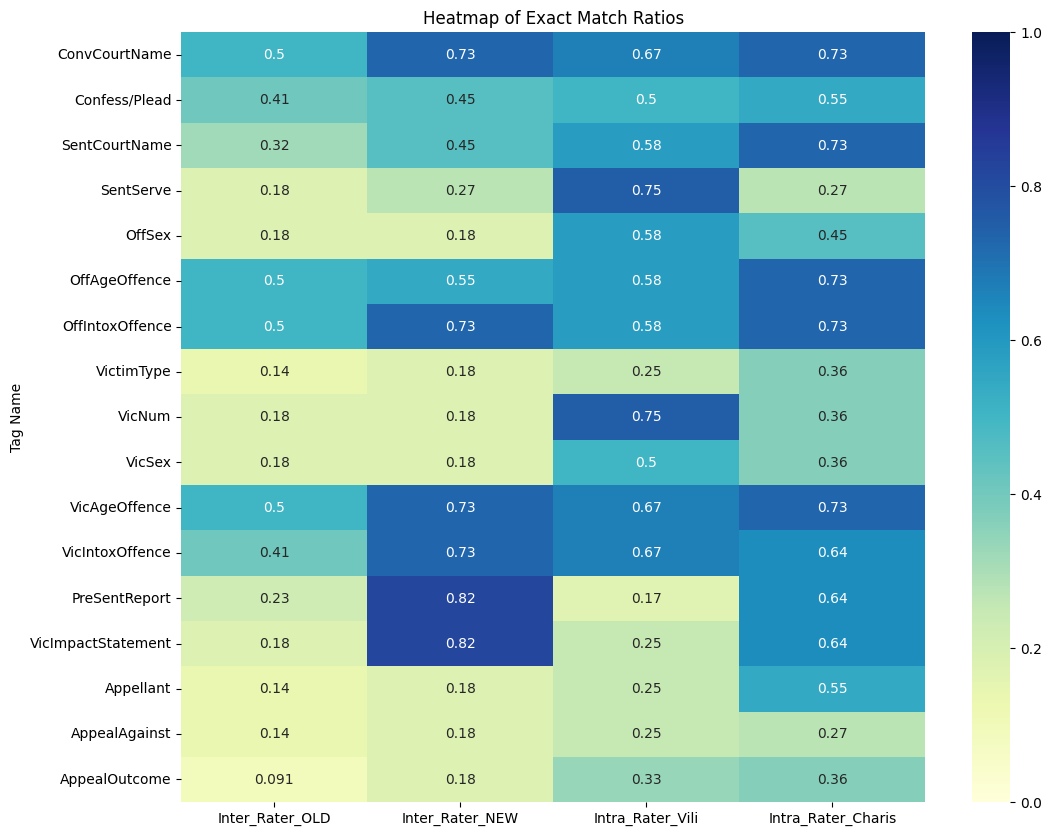

In [8]:
import seaborn as sns

# Suppose you combine your comparisons into a single DataFrame where rows are tags and
# columns are, say, "Inter_Rater_OLD", "Inter_Rater_NEW", etc.
combined_df = pd.DataFrame({
    "Inter_Rater_OLD": exact_inter_old.set_index("Tag Name")["Exact Match"],
    "Inter_Rater_NEW": exact_inter_new.set_index("Tag Name")["Exact Match"],
    "Intra_Rater_Vili": exact_intra_vili.set_index("Tag Name")["Exact Match"],
    "Intra_Rater_Charis": exact_intra_charis.set_index("Tag Name")["Exact Match"]
})
plt.figure(figsize=(12, 10))
sns.heatmap(combined_df, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Heatmap of Exact Match Ratios")
plt.show()
